## Dataset, exploratory analysis and baseline comparation

In [39]:
# imports

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [4]:
# load original file and count the available columns

data = pd.read_csv('Cobrancas_Telefonia.csv',sep=';',decimal=',', encoding = 'ISO-8859-1',low_memory=False)
print("Dataset has {} rows with {} columns each.".format(*data.shape))

# extract online columns not related to personal identification of the debts

cob_cols = ['TIPO_PES','SEXO_PES','ESTADO_CIVIL_PES','IDADE','VALOR_TOTAL','ATRASO','NOME_TIPE','TEVE_DEVOL','CIDADES','UF','RESULTADO']

data = data[cob_cols]

# convert the class from values "S" (yes in portuguese) and "N" (No in portuguese) to 1/0
class_dict = { 'N' : 0 , 'S': 1} 

data["RESULTADO"].replace(class_dict, inplace=True)

print("Dataset has {} rows with {} columns each.".format(*data.shape))

# save the new dataset with the allowed columns

data.to_csv('Debts.csv',sep=';', index=False)

Dataset has 848091 rows with 42 columns each.
Dataset has 848091 rows with 11 columns each.


In [7]:
# check for columns and types

data.dtypes

TIPO_PES             object
SEXO_PES             object
ESTADO_CIVIL_PES     object
IDADE               float64
VALOR_TOTAL         float64
ATRASO                int64
NOME_TIPE            object
TEVE_DEVOL            int64
CIDADES              object
UF                   object
RESULTADO             int64
dtype: object

In [13]:
# check for class distribution

classname="RESULTADO"
data[classname].value_counts()

0    804689
1     43402
Name: RESULTADO, dtype: int64

Only 43.402 rows from positive class - 5,39%

In [8]:
# check the first rows

data.head()

,TIPO_PES,SEXO_PES,ESTADO_CIVIL_PES,IDADE,VALOR_TOTAL,ATRASO,NOME_TIPE,TEVE_DEVOL,CIDADES,UF,RESULTADO
0,NaN,M,NaN,11.0,424.71,191,RESIDENCIAL,0,JOAO PESSOA ...,PB,0
1,NaN,M,C,34.0,43.23,195,RESIDENCIAL,0,FOZ DO IGUACU ...,PR,0
2,NaN,M,NaN,25.0,274.14,160,RESIDENCIAL,0,CUIABA ...,MT,0
3,NaN,F,,NaN,332.64,219,RESIDENCIAL,0,POUSO ALEGRE ...,MG,0
4,NaN,M,NaN,46.0,94.75,191,RESIDENCIAL,0,NITEROI ...,RJ,0


Lots of null values... and columns with categorical values, like CIDADES, that must be converted with One hot encoding or Label encoding;

In [11]:
# check total possible values for cidades

data['CIDADES'].nunique()

2599

With 2599 possible values, is better no to use one hot encoding, that results in 2599 new columns. Better use label encoding, meaning that each one of the values are assigned to a number (0,1,2,3...) and stored in just one column.

In [9]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum()/len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 
    
missing_values_table(data)

,Missing Values,% of Total Values
TIPO_PES,819791,96.663094
SEXO_PES,771789,91.003088
ESTADO_CIVIL_PES,824183,97.180963
IDADE,811616,95.699164
VALOR_TOTAL,0,0.000000
ATRASO,0,0.000000
NOME_TIPE,11,0.001297
TEVE_DEVOL,0,0.000000
CIDADES,11,0.001297
UF,11,0.001297


In [15]:
# repair the null values, using:
# - the most common value for categoric attributes
# - the mean value for numeric attributes

for col, col_type in data.dtypes.iteritems():
    if col != classname:
        if col_type == 'O':
            data[col].fillna(data[col].value_counts().index[0], inplace=True)
        else:
            data[col].fillna(data[col].median(), inplace=True)

In [21]:
# apply label encoder on categoric attributes

for col, col_type in data.dtypes.iteritems():
    if col != classname:
        if col_type == 'O':
            data[col] = data[col].astype('category')
            print("Column " + col + " has " + str(len(data[col].cat.categories)) + " distinct values, using label encoder")    
            data[col] = data[col].cat.codes

Column SEXO_PES has 4 distinct values, using label encoder
Column ESTADO_CIVIL_PES has 12 distinct values, using label encoder
Column NOME_TIPE has 4 distinct values, using label encoder
Column CIDADES has 2599 distinct values, using label encoder
Column UF has 27 distinct values, using label encoder


LogisticRegression - Train perf.: 62.69% - Tests perf: 62.57% - Accuracy: 0.6256905181612908 - AUC: 0.6135234559669627
SVC - Train perf.: 94.90% - Tests perf: 94.81% - Accuracy: 0.9480836462896256 - AUC: 0.5124703700983019
DecisionTree - Train perf.: 99.94% - Tests perf: 99.68% - Accuracy: 0.9967810209941104 - AUC: 0.980407329784264
NB - Train perf.: 91.56% - Tests perf: 91.55% - Accuracy: 0.9155460178399826 - AUC: 0.610747809479365
KNN - Train perf.: 98.48% - Tests perf: 97.30% - Accuracy: 0.972951143445015 - AUC: 0.9497255325832801


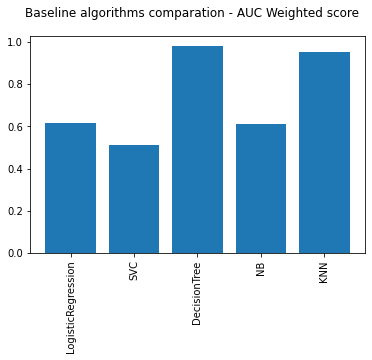

In [41]:
# create a baseline comparation with 5 common classifiers
# important! All classifiers uses the parameter class_weight ='balanced', to adjust the class imbalance
# use metrics accuracy and AUC weighted, to better compare with others results in Azure AutoML

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', category=ConvergenceWarning)

classifiers={ 'LogisticRegression' : LogisticRegression(class_weight='balanced', random_state=50),
              'SVC' : LinearSVC(class_weight='balanced',random_state=50),
              'DecisionTree': DecisionTreeClassifier(class_weight ='balanced',random_state=50),
              'NB' : GaussianNB(),
              'KNN' : KNeighborsClassifier()
            }

def do_train(title,df,clf,classname,percentual):
    x = df[df.columns.difference([classname])]
    y = df[classname]
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=percentual, random_state=50)
   
    clf.fit(X_train, y_train)
    
    score_train = clf.score(X_train, y_train)
    score_tests = clf.score(X_test, y_test)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)

    # uses decision_function in some classifiers (LogisticRegression, SVC) and predict_proba in others (DecisionTree, NB, KNN)
    if  callable(getattr(clf, "decision_function", None)):
        auc_weighted = roc_auc_score(y_test,clf.decision_function(X_test))
    else:
        auc_weighted = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
    
    train_perf = '{:.2f}'.format(float(score_train)*100)
    test_perf = '{:.2f}'.format(float(score_tests)*100)
    print(title + ' - Train perf.: ' + train_perf + '% - Tests perf: ' + test_perf + '%' + ' - Accuracy: ' + str(accuracy) + ' - AUC: ' + str(auc_weighted))
    return auc_weighted
    
results = []
names = []
for title, model in classifiers.items():
    auc = do_train(title,data,model,'RESULTADO',0.20)
    results.append(auc)
    names.append(title)

fig = plt.figure()
fig.suptitle('Baseline algorithms comparation - AUC Weighted score')
ax = fig.add_subplot(111)
ind = np.arange(1, len(classifiers.keys())+1)
plt.bar(ind,results)
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.xticks(rotation=90)
plt.show()

As seen in the graph, the best algorithm for the dataset was DecisionTree, with Accuracy of 0.996 and AUC of 0.980, classifying almost 100% of training and testing records correctly.

This will be the algorithm to be used for tuning hyperparameters with Azure Hyperdrive.